# 95828 Final Project Code Submission
## Amy Huang, amyh1@andrew.cmu.edu
## Wei-Kung Wang, weikungw@andrew.cmu.edu


In [1]:
import time
import re
import collections
import os
import pickle
import sys
import json
import codecs
import datetime
import numpy as np
import pandas as pd
import string
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
# plt.style.use('ggplot')
style.use('fivethirtyeight')

# Loading Data and Processing Data

1. Randomly select 20000 playlists from the Million Playlist Dataset.
2. Process the data to be ready to create the sparse matrix

In [7]:
# Initiate variables
playlist_count = 0
row_idx = 0
col_idx = 0
row_idx_ls = [] # list of row indexes of data, required for creating sparse matrix
col_idx_ls = [] # list of column indexes of data, required for creating sparse matrix
pid_row_dict = dict() # lookup dict for playlist id and it's row index in the playlist-track matrix
pid_name_dict = dict() # lookup dict for playlist id and it's name
track_col_dict = dict() # lookup dict for track and it's column index in the playlist-track matrix
track_info_dict = dict() 
counter = 0
cache = {}

# find the correspoding json file according to the playlist id (pid)
def find_playlist(pid):
    if pid >=0 and pid < 1000000:
        low = 1000 * int(pid / 1000)
        high = low + 999
        offset = pid - low
        path = "data/mpd.slice." + str(low) + '-' + str(high) + ".json"
        f = codecs.open(path, 'r', 'utf-8')
        js = f.read()
        f.close()
        playlist = json.loads(js)
        playlist = playlist['playlists'][offset]
    return playlist

# 
def process_playlist(playlist):
    global playlist_count, row_idx, col_idx, row_idx_ls, col_idx_ls, pid_row_dict, pid_name_dict, track_col_dict, track_info_dict, counter

    pid = playlist["pid"]
    pid_row_dict[pid] = row_idx
    pid_name_dict[pid] = playlist["name"]
    for track in playlist['tracks']:
        track_uri = track['track_uri']
        if track_uri not in track_col_dict:
            track_col_dict[track_uri] = col_idx
            col_idx += 1
        col_idx_ls.append(track_col_dict[track_uri])
        row_idx_ls.append(row_idx)
        track_info_dict[track['track_uri']] = (track['track_name'],track['artist_uri'],track['artist_name'])
    row_idx += 1
    playlist_count += 1
    if playlist_count%1000 == 0:
        with open("backup.pkl", "wb") as file:
            pickle.dump((playlist_count,
                        row_idx,
                        col_idx,
                        row_idx_ls,
                        col_idx_ls,
                        pid_row_dict,
                        pid_name_dict,
                        track_col_dict,
                        track_info_dict),file)
    pass

# 
rand_pids = np.random.choice(a = 1000000, size = 20000, replace = False)
for pid in rand_pids:
    process_playlist(find_playlist(pid))

In [ ]:
# save the result into a pickle file
with open("backup_20000_20180428.pkl", "wb") as file:
        pickle.dump((playlist_count,
                    row_idx, 
                    col_idx, 
                    row_idx_ls, # list of row indexes of data, required for creating sparse matrix
                    col_idx_ls, # list of column indexes of data, required for creating sparse matrix
                    pid_row_dict, # lookup dict for playlist id and it's row index in the playlist-track matrix
                    pid_name_dict, # lookup dict for playlist id and it's name
                    track_col_dict, # lookup dict for track and it's column index in the playlist-track matrix
                    track_info_dict),file)
# the link to the pickle file: https://drive.google.com/file/d/1J7F-xiw-A2Re0S0F2lTfOp5Yk4v_kcWS/view?usp=sharing

# Exploratory Data Analysis

Prepate the data for EDA to:
1. Find the top popular artists
2. Find the top popular songs
3. Calculate the number of songs in each playlist and plot the distribution

In [3]:
# load data from the pickle file
with open ('pickles/data/backup_20000_20180428.pkl', 'rb') as file:
    (playlist_count,
     row_idx,
     col_idx,
     row_idx_ls, # list of row indexes of data, required for creating sparse matrix
     col_idx_ls, # list of column indexes of data, required for creating sparse matrix
     pid_row_dict, # lookup dict for playlist id and it's row index in the playlist-track matrix
     pid_name_dict, # lookup dict for playlist id and it's name
     track_col_dict, # lookup dict for track and it's column index in the playlist-track matrix
     track_info_dict) = pickle.load(file)

In [4]:
# the idx of tracks ordered by number of occurence in the 20000 playlists
count_tracks = collections.Counter(col_idx_ls)
ranked_track_idx = [i[0] for i in count_tracks.most_common()]
ranked_track_count = [i[1] for i in count_tracks.most_common()]

In [5]:
col_track_dict = {v: k for k, v in track_col_dict.items()}

In [6]:
ranked_trackNames = [track_info_dict[col_track_dict[i]][0] for i in ranked_track_idx]

In [7]:
track_artist_ls = [track_info_dict[col_track_dict[i]][2] for i in col_idx_ls]

In [8]:
# count the number of occurene of artist
count_artist = collections.Counter(track_artist_ls)
ranked_artist = [i[0] for i in count_artist.most_common()]
ranked_artist = [(''.join(x if x not in string.punctuation else '' for x in i)).strip() for i in ranked_artist]
ranked_artist_count = [i[1] for i in count_artist.most_common()]

## Plotting the Occurence (Popularity) of Tracks

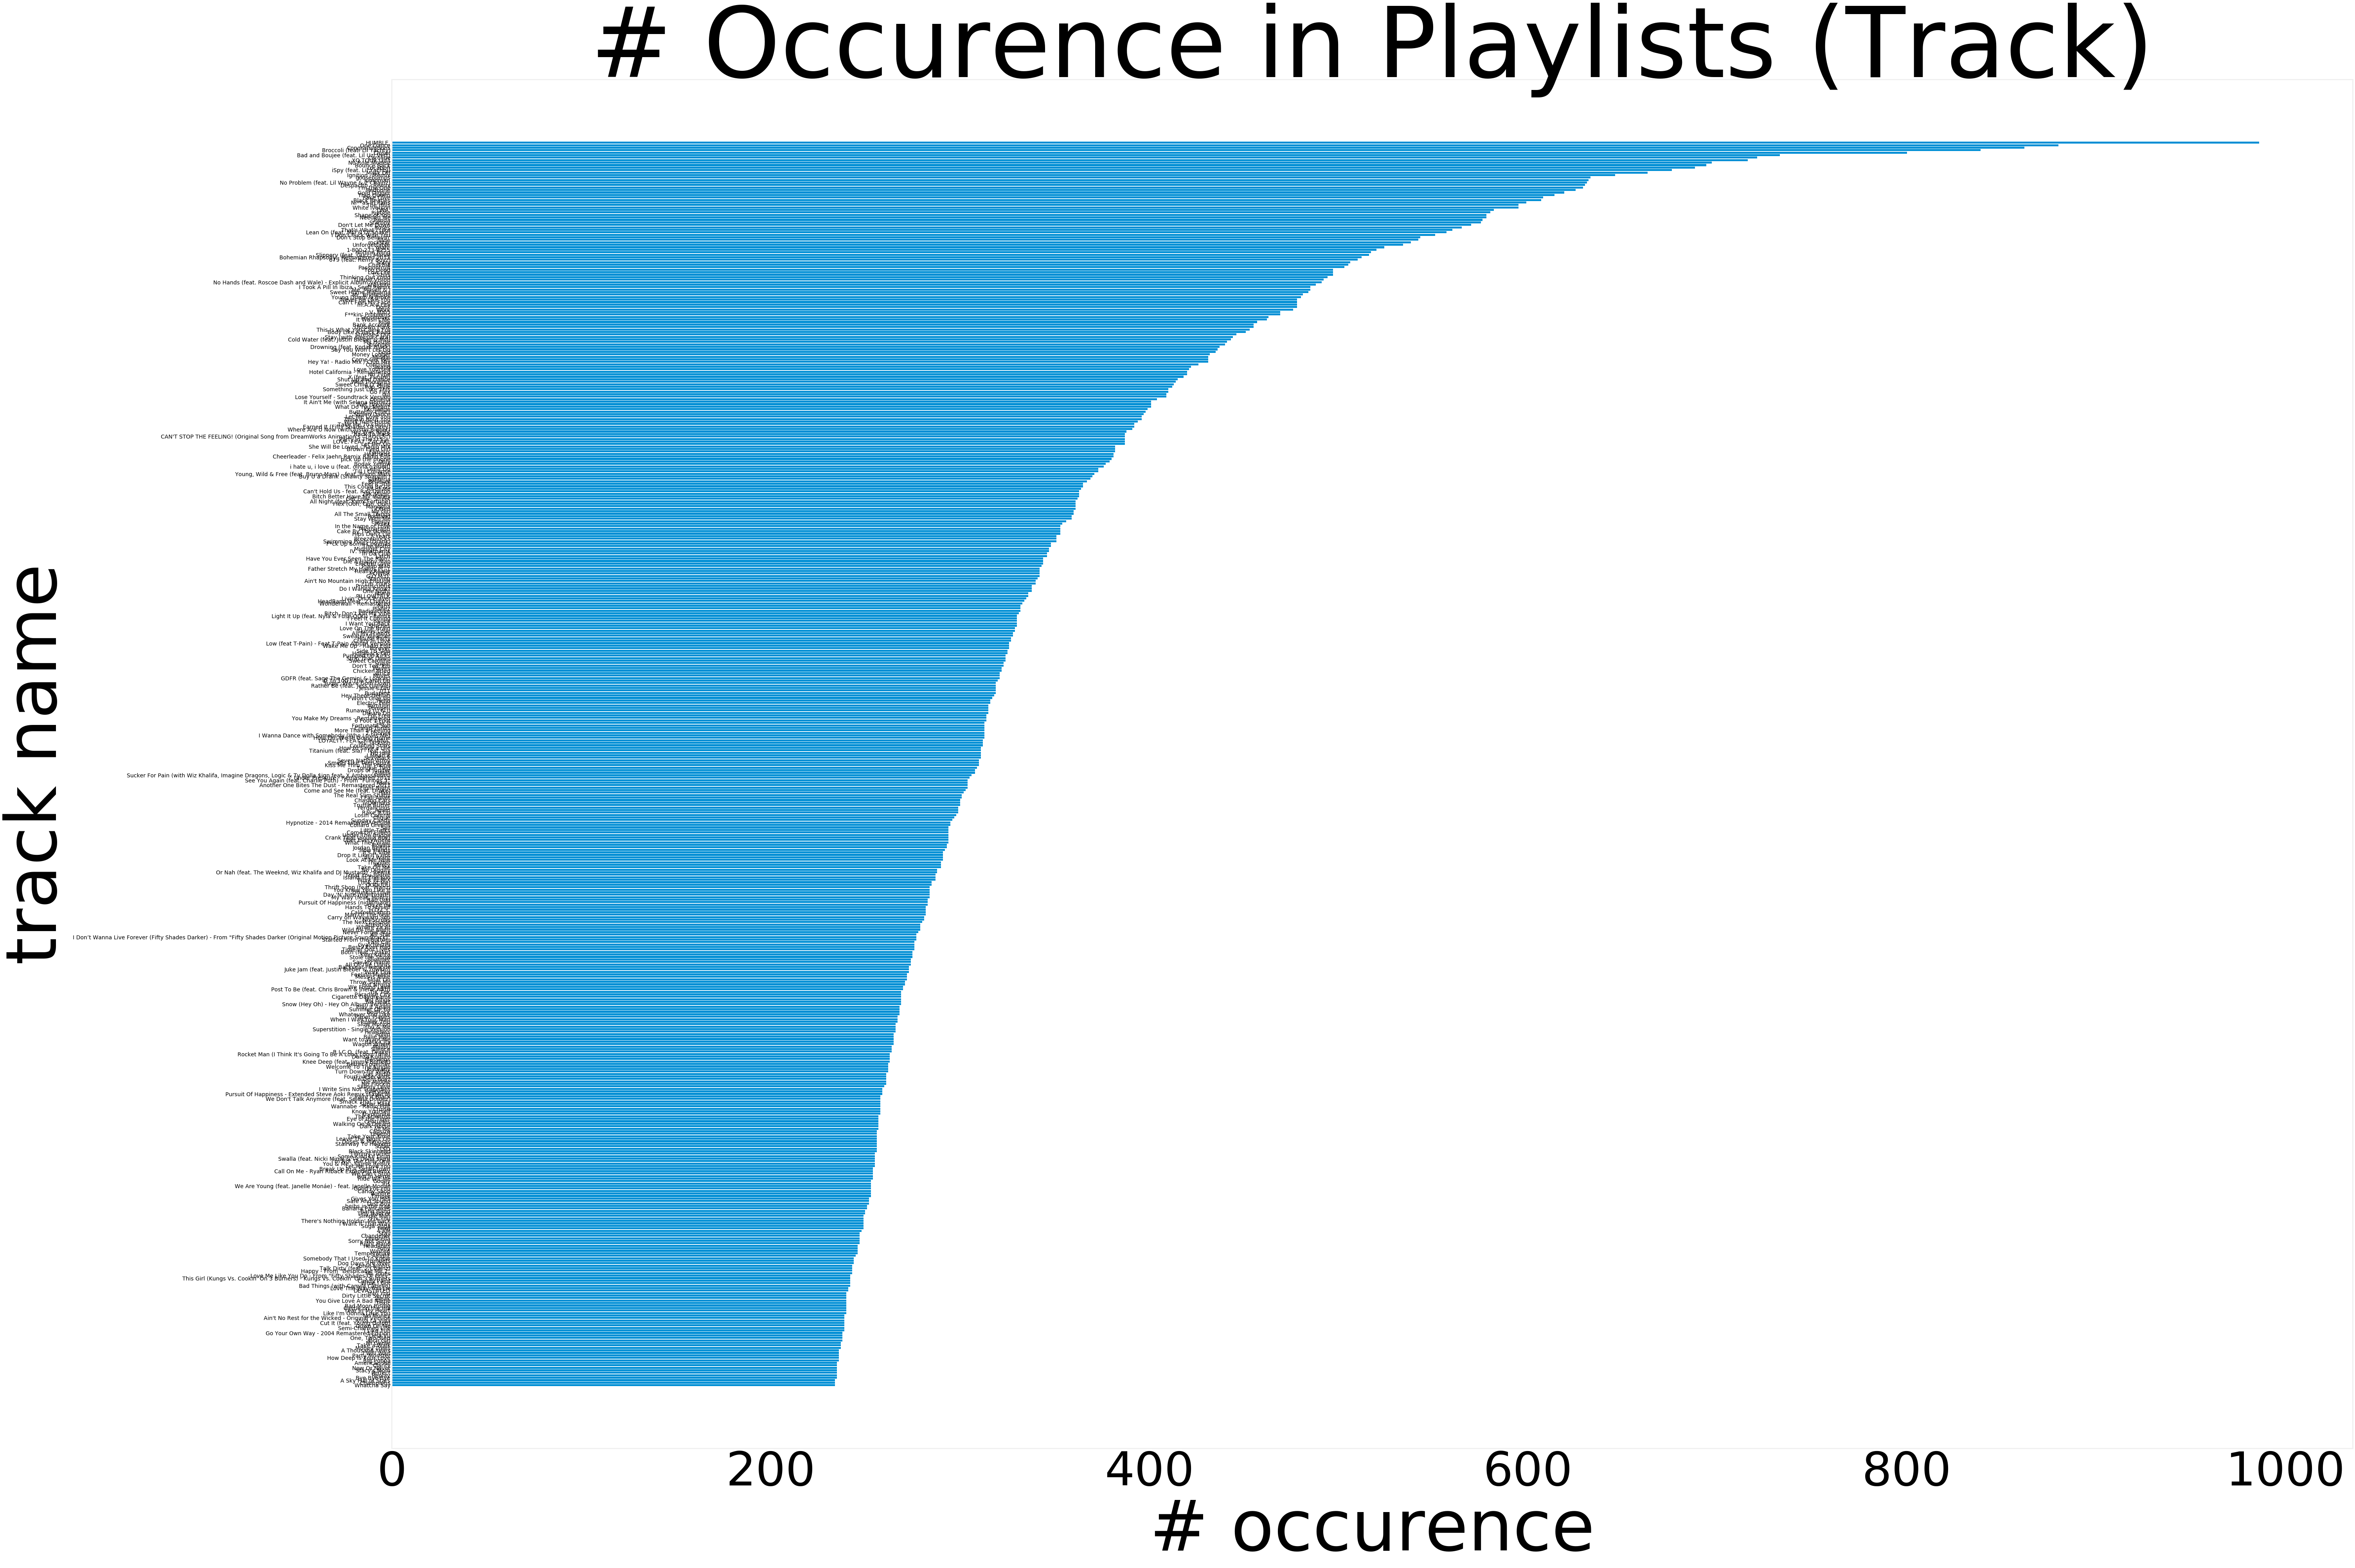

In [9]:
fig = plt.figure(figsize=(80,60), facecolor = 'white')
ax = fig.add_subplot(111, facecolor='white')
y_pos = np.arange(len(ranked_trackNames[:500]))
ax.barh(y_pos, ranked_track_count[:500][::-1], align="center", color = 'C0')
ax.grid(False)

ax.set_xlabel('# occurence', fontsize=180)
ax.set_ylabel('track name', fontsize=180)
ax.set_title('# Occurence in Playlists (Track)', fontsize = 250)
plt.xticks(fontsize = 120)
plt.yticks(y_pos, ranked_trackNames[:500][::-1])
plt.savefig('track_occur.png', facecolor = 'white', bbox_inches = 'tight')
plt.show()

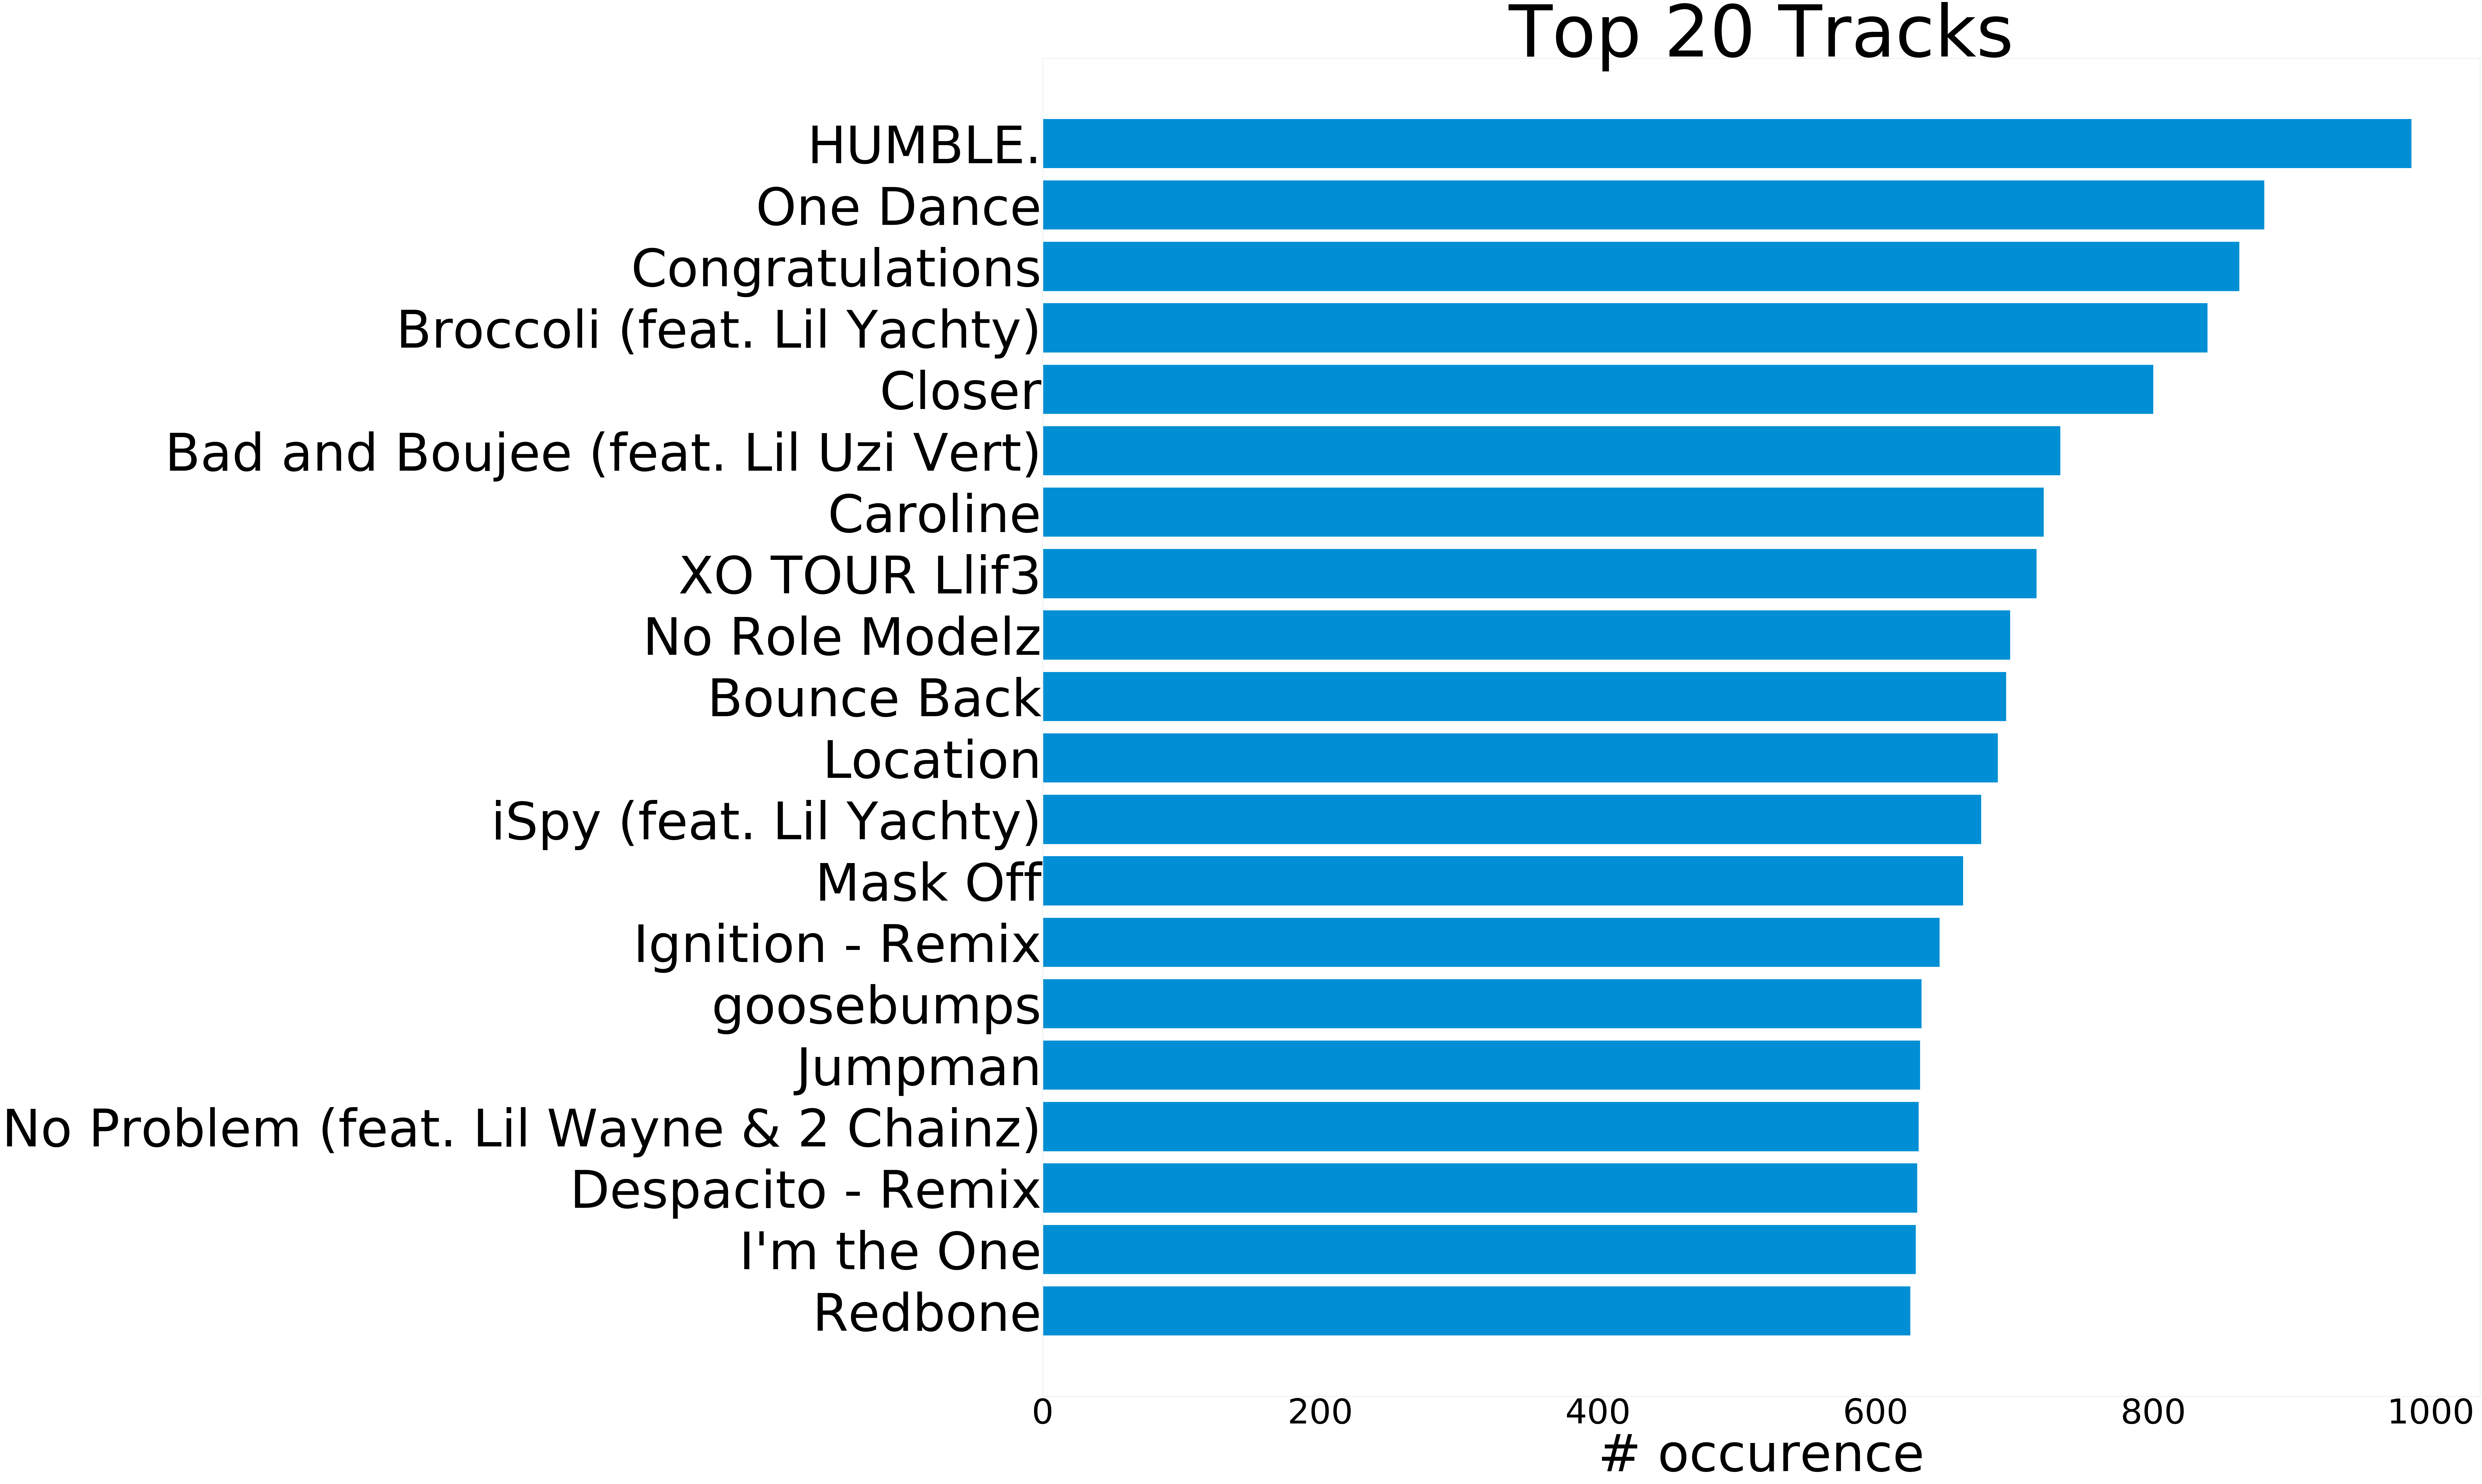

In [10]:
fig = plt.figure(figsize=(80,80), facecolor = 'white')
ax = fig.add_subplot(111, facecolor='white')
y_pos = np.arange(len(ranked_trackNames[:20]))
ax.barh(y_pos, ranked_track_count[:20][::-1], align="center", color = 'C0')
ax.grid(False)

ax.set_xlabel('# occurence', fontsize=180)
ax.set_title('Top 20 Tracks', fontsize = 250)
plt.xticks(fontsize = 120)
plt.yticks(y_pos, ranked_trackNames[:20][::-1], fontsize = 180)
plt.savefig('top20_track.png', facecolor = 'white', bbox_inches = 'tight')
plt.show()

## Plotting the Occurence (Popularity) of Artists

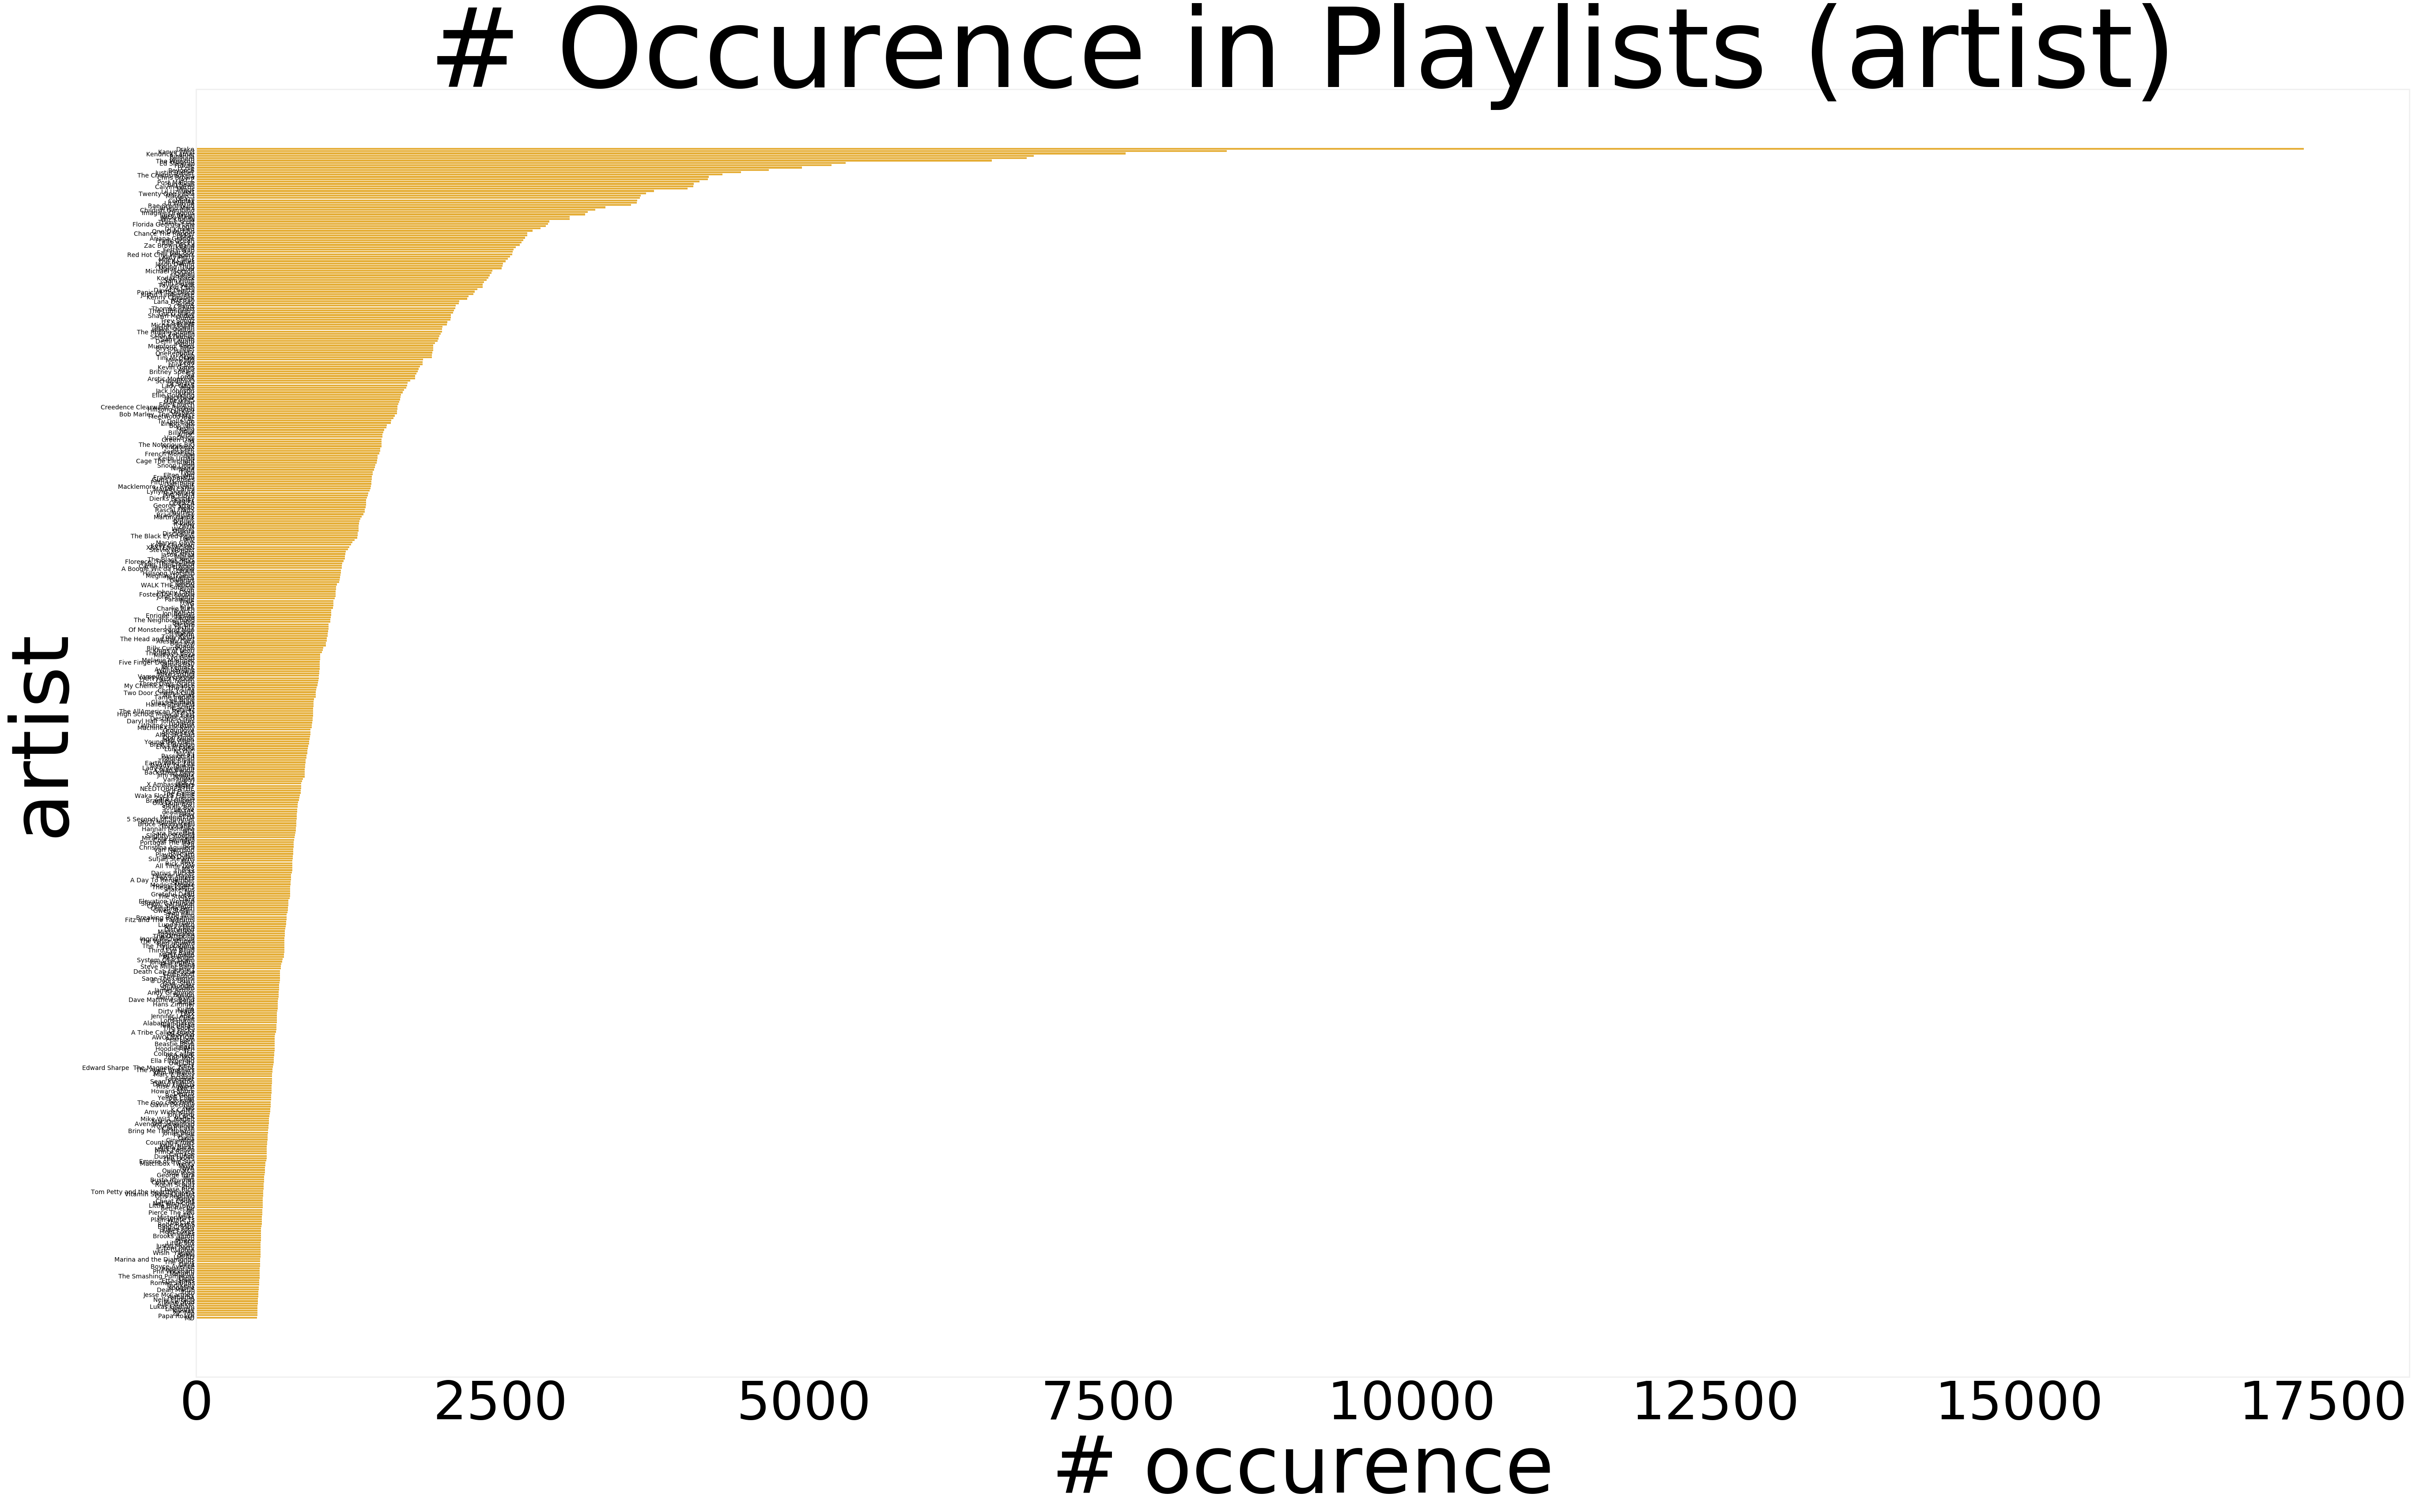

In [11]:
fig = plt.figure(figsize=(80,50), facecolor = 'white')
ax = fig.add_subplot(111, facecolor='white')
y_pos = np.arange(len(ranked_artist[:500]))
ax.barh(y_pos, ranked_artist_count[:500][::-1], align="center", color = 'C8')
ax.grid(False)

ax.set_xlabel('# occurence', fontsize=180)
ax.set_ylabel('artist', fontsize=180)
ax.set_title('# Occurence in Playlists (artist)', fontsize = 250)
plt.xticks(fontsize = 120)
plt.yticks(y_pos, ranked_artist[:500][::-1])
plt.savefig('artist_occur.png', facecolor = 'white', bbox_inches = 'tight')
plt.show()

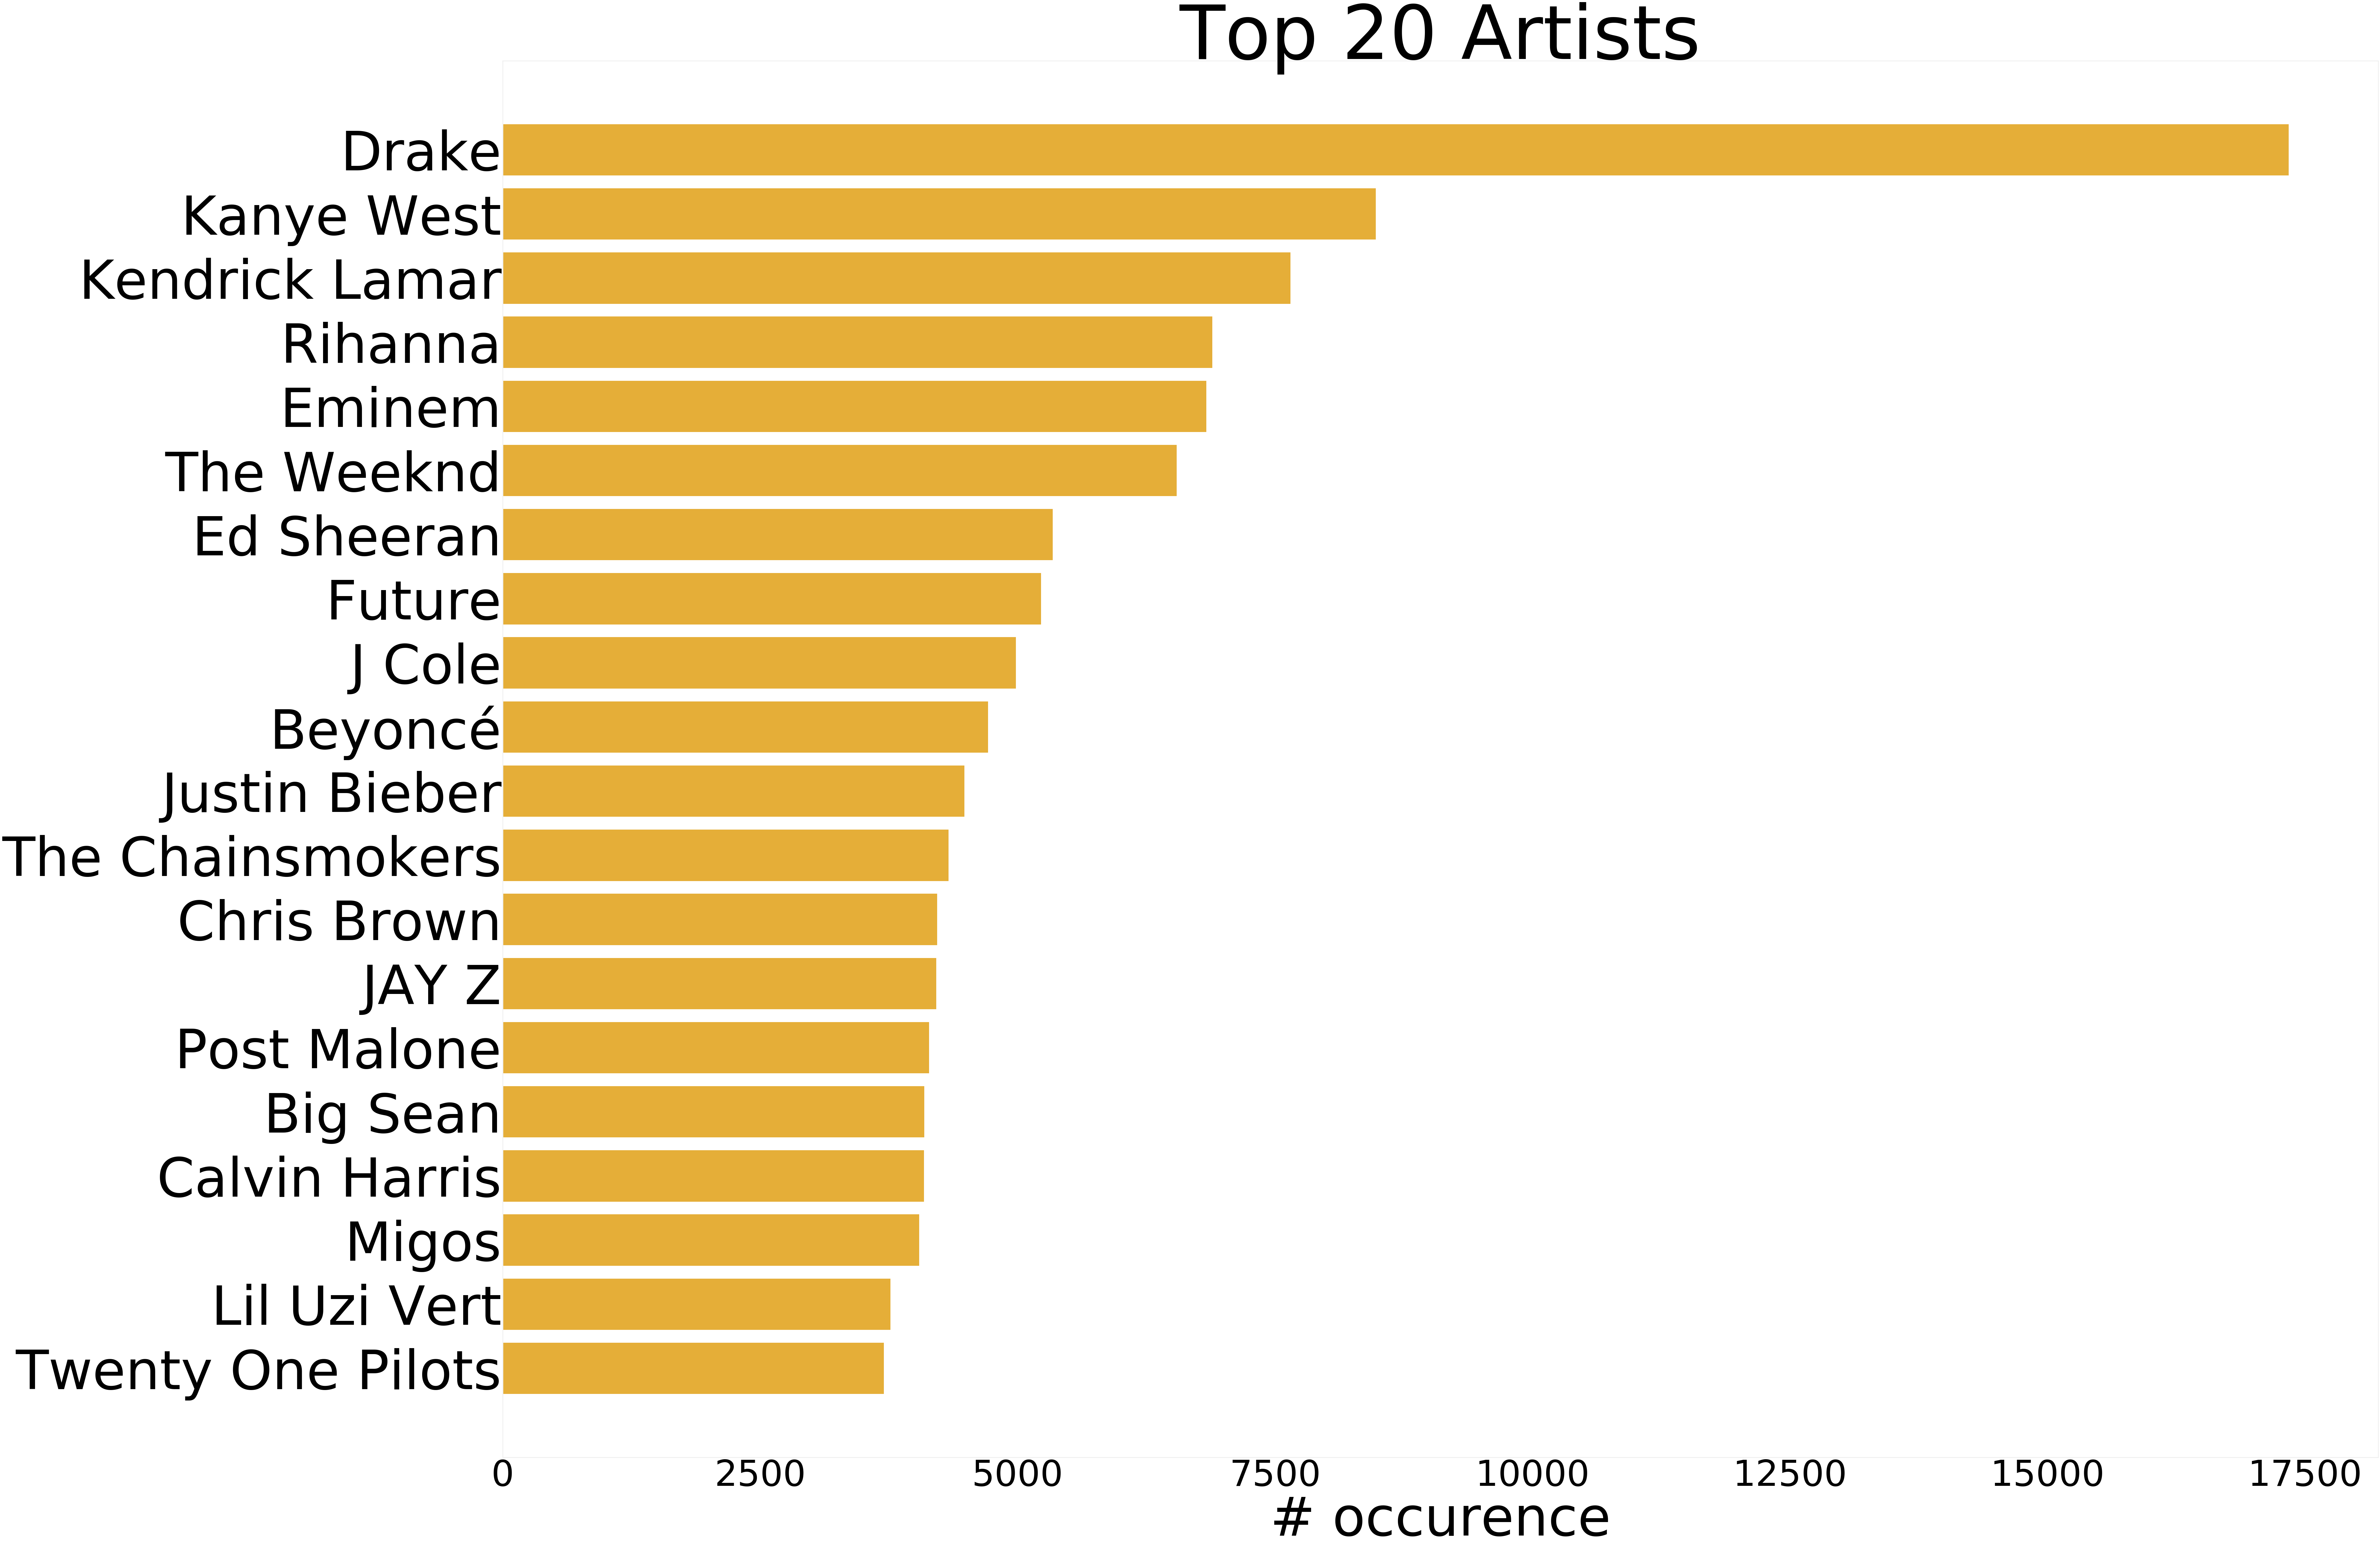

In [12]:
fig = plt.figure(figsize=(100,80), facecolor = 'white')
ax = fig.add_subplot(111, facecolor='white')
y_pos = np.arange(len(ranked_artist[:20]))
ax.barh(y_pos, ranked_artist_count[:20][::-1], align="center", color = 'C8')
ax.grid(False)

ax.set_xlabel('# occurence', fontsize=180)
ax.set_title('Top 20 Artists', fontsize = 250)
plt.xticks(fontsize = 120)
plt.yticks(y_pos, ranked_artist[:20][::-1], fontsize = 180)
plt.savefig('top20_artist.png', facecolor = 'white', bbox_inches = 'tight')
plt.show()

## Plotting Distribution of Playlist Length

In [ ]:
# modified from description.py provided with MPD dataset
def find_playlist(pid):
    global cache
    if pid >=0 and pid < 1000000:
        low = 1000 * int(pid / 1000)
        high = low + 999
        offset = pid - low
        path = "data/mpd.slice." + str(low) + '-' + str(high) + ".json"
#         path = "/Users/Amyhuang/Documents/AMY/CMU/2018Spring/ML for Problem Solving/Final_Project/data/mpd.slice." + str(low) + '-' + str(high) + ".json"
        f = codecs.open(path, 'r', 'utf-8')
        js = f.read()
        f.close()
        playlist = json.loads(js)
        playlist = playlist['playlists'][offset]
    return playlist

def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@]", ' ', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [ ]:
pids = list(pid_row_dict.keys())
playlist_length_histogram = collections.Counter()
title_histogram = collections.Counter()
ntitles = set()
titles = set()

for idx, pid in enumerate(pids):
    playlist = find_playlist(pid)
    playlist_length_histogram[playlist['num_tracks']] += 1
    titles.add(playlist['name'])
    nname = normalize_name(playlist['name'])
    ntitles.add(nname)
    title_histogram[nname] += 1
    if (idx+1) % 100 == 0:
        print(idx+1, 'playlists searched')

In [ ]:
playlist_length_ls = []
for key, value in playlist_length_histogram.items():
    playlist_length_ls.extend([key]*value)

In [ ]:
fig = plt.figure(figsize=(100,60), facecolor = 'white')
ax = fig.add_subplot(111, facecolor='white')
y_pos = np.arange(len(ranked_artist[:20]))
ax.hist(playlist_length_ls, bins = len(playlist_length_num))
ax.grid(False)

ax.set_xlabel('# tracks in playlist', fontsize=180)
ax.set_title('Playlist Length', fontsize = 250)
plt.xticks(fontsize = 120)
plt.yticks(fontsize = 120)
plt.savefig('playlist_length.png', facecolor = 'white', bbox_inches = 'tight')
plt.show()

# Test-train split

Masking some of the tracks in the playlist to be the test data

In [ ]:
def split_test_train(split_ratio,
                     col_idxs,
                     row_idxs,
                     data,
                     random_state=0):
    import numpy as np
    import math
    np.random.seed(random_state)
    P = np.random.permutation(len(col_idxs))
    col_idxs = np.asarray(col_idxs)
    row_idxs = np.asarray(row_idxs)
    data = np.asarray(data)
    train_mask = np.asarray(P[math.floor(len(P)*split_ratio):]).astype(int)
    test_mask = np.asarray(P[:math.floor(len(P)*split_ratio)]).astype(int)
    train_row_idxs = row_idxs[train_mask]
    train_col_idxs = col_idxs[train_mask]
    train_data = data[train_mask]
    test_row_idxs = row_idxs[test_mask]
    test_col_idxs = col_idxs[test_mask]
    test_data = data[test_mask]
    

    return (train_row_idxs, train_col_idxs, train_data, test_row_idxs, test_col_idxs, test_data)

In [ ]:
data = list(np.ones(len(row_idx_ls)))

# 80-20 split data into (train set + validation set) and test set
(_row_idxs, _col_idxs, _data, 
 test_row_idxs, test_col_idxs, test_data) = split_test_train(split_ratio = 0.2,
                                                             col_idxs = col_idx_ls,
                                                             row_idxs = row_idx_ls,
                                                             data = data,
                                                             random_state=0)
# 80-20 split (train set + validation set) into train set and validation set
(train_row_idxs, train_col_idxs, train_data, 
 val_row_idxs, val_col_idxs, val_data) = split_test_train(split_ratio = 0.2,
                                                             col_idxs = _col_idxs,
                                                             row_idxs = _row_idxs,
                                                             data = _data,
                                                             random_state=0)

# Creating the Sparse Matrix

In [ ]:
import scipy.sparse
weight = 1
p = np.max(row_idx_ls)+1
t = np.max(col_idx_ls)+1

X_train = sp.sparse.coo_matrix((train_data*weight, (train_row_idxs, train_col_idxs)), shape=(p, t))
X_test = sp.sparse.coo_matrix((test_data*weight, (test_row_idxs, test_col_idxs)), shape=(p, t))
X_val = sp.sparse.coo_matrix((val_data*weight, (val_row_idxs, val_col_idxs)), shape=(p, t))

In [ ]:
print("Train matrix shape", X_train.shape)
print("Train matrix data size", X_train.nnz)
print("Test matrix shape", X_test.shape)
print("Test matrix data size", X_test.nnz)
print("Validation matrix shape", X_val.shape)
print("Validation matrix data size", X_val.nnz)

In [ ]:
# save X_train, X_test, X_val
with open("pickles/20000_train_test_val", "wb") as file:
    pickle.dump((X_train, X_test, X_val), file)
    
# link to the data: https://drive.google.com/file/d/1lNY_FD45xPz4iUR9usHmfXEx9WGbvw_J/view?usp=sharing

# Defining the Evaluation Metrics

1. Precision at K
2. NDCG at K

In [12]:
# average precision at k
def precision_at_k(X_test, pred):
    precision = []
    k = len(pred[0])
    n, m = X_test.shape
    for userid in range(n):
        in_test = X_test.tocsr()[userid,:].nonzero()[1].tolist()
        g_and_pred = len(set(in_test).intersection(set(pred[userid])))
        if in_test:
            prec = g_and_pred/k
            precision.append(prec)
        print("Finished playlist", userid+1, 'prec', prec)
    print("Final precision at K", np.mean(precision))
    return np.mean(precision)

# average ndcg at k
def cal_ndcg(X_test, pred):
    pred = np.asarray(pred)
    u = X_test.shape[0]
    k = 10
    idcg = [1]
    for i in range(2,k+1):
        idcg.append(1/np.log2(i))
    idcg = np.asarray(idcg)
    dcg = 0
    for userid in range(u):
        dcg += np.in1d(pred[userid], X_test.tocsr()[userid,:].nonzero()[1].tolist()).dot(idcg)
        if userid%1000==0: 
            print("Finish userid", userid)
    print("============")
    print("Average ndcg:", dcg/idcg.sum()/u)
    return (dcg/idcg.sum()/u)

# Training Models

Training models with different hyper parameters

In [13]:
# load X_train, X_test, X_val
with open("pickles/data/20000_train_test_val", "rb") as file:
    (X_train, X_test, X_val) = pickle.load(file)

In [14]:
# list of n_component
n_ls = [10, 25, 50, 100, 1000]
# list of regularization term(alpha)
alpha_ls = [0.1, 0.01, 0.001]
info_dict = {}

In [17]:
# You might need to install this package through pip
import implicit
for n_ in n_ls:
    for alpha_ in alpha_ls:
        n = n_
        alpha = alpha_
        recommendations = []
        # initialize a model
        model = implicit.als.AlternatingLeastSquares(factors=n,
                                                     regularization=alpha,
                                                     use_native=True,
                                                     use_cg=True,
                                                     use_gpu=False,
                                                     iterations=20,
                                                     calculate_training_loss=True,
                                                     num_threads=0)
        
        # train the model on a sparse matrix of item/user/confidence weights
        model.fit(X_train.T)


        # recommend items for a user
        pred = []
        user_items = X_train.tocsr()
        for userid in range(X_train.shape[0]):
            temp = []
            filter_items = user_items[userid,:].nonzero()[1].tolist()
            temp_rec = model.recommend(userid,
                                       user_items=user_items,
                                       filter_items=filter_items)
            for tup in temp_rec:
                temp.append(tup[0])
            pred.append(temp)
            if userid%1000==0:
                print(userid, "Done")
        # calculate precision@k and NDCG@k
        precision = precision_at_k(X_val, pred)
        average_ndcg = cal_ndcg(X_val, pred)
        H = model.item_factors
        W = model.user_factors
        info = ''.join(['n', str(n_), '_', 'a', ''.join(re.findall('[0-9]+', str(alpha_))), '_ndcgok'])
        file_path = "pickles/model/ndcg_val/als_"+info+".pkl"
        
        # save the model into a pickle file
        with open(file_path, "wb") as file:
            pickle.dump((model, W, H, info, precision, average_ndcg),file)
        
        # save the model information and the perfomance in a dictionary
        info_dict['als_' + info] = 'n='+str(n_)+', alpha=' + str(alpha_) + ', precision at k=' + str(precision) + 'correct_ndcg_'+str(average_ndcg)

In [ ]:
# save the info dictionary into a pickle
with open('pickles/model/ndcg_val/info_dict', 'wb') as file:
    pickle.dump(info_dict, file)
# data link: https://drive.google.com/open?id=1FBCAc6PwvjwjwRfMrgZ0y4EgT2tkP2WS

# Choosing the Hyper parameters

In [26]:
# load the info dict
with open('pickles/model/ndcg_val/info_dict', 'rb') as file:
    info = pickle.load(file)
keys = []
values = []
for key, value in info.items():
    keys.append(key)
    values.append(value)

In [27]:
import pandas as pd
pk_df=pd.DataFrame(index=['0.001','0.01','0.1'], columns=['1000','100', '50', '25', '10'])
ndcg_df=pd.DataFrame(index=['0.001','0.01','0.1'], columns=['1000','100', '50', '25', '10'])

In [28]:
for v in values:
    a = re.findall('[0-9.]+', v)
    pk_df[a[0]][a[1]] = float(a[2])
    ndcg_df[a[0]][a[1]] = float(a[-1])

In [29]:
pk_df.fillna(value=np.nan, inplace=True)
ndcg_df.fillna(value=np.nan, inplace=True)

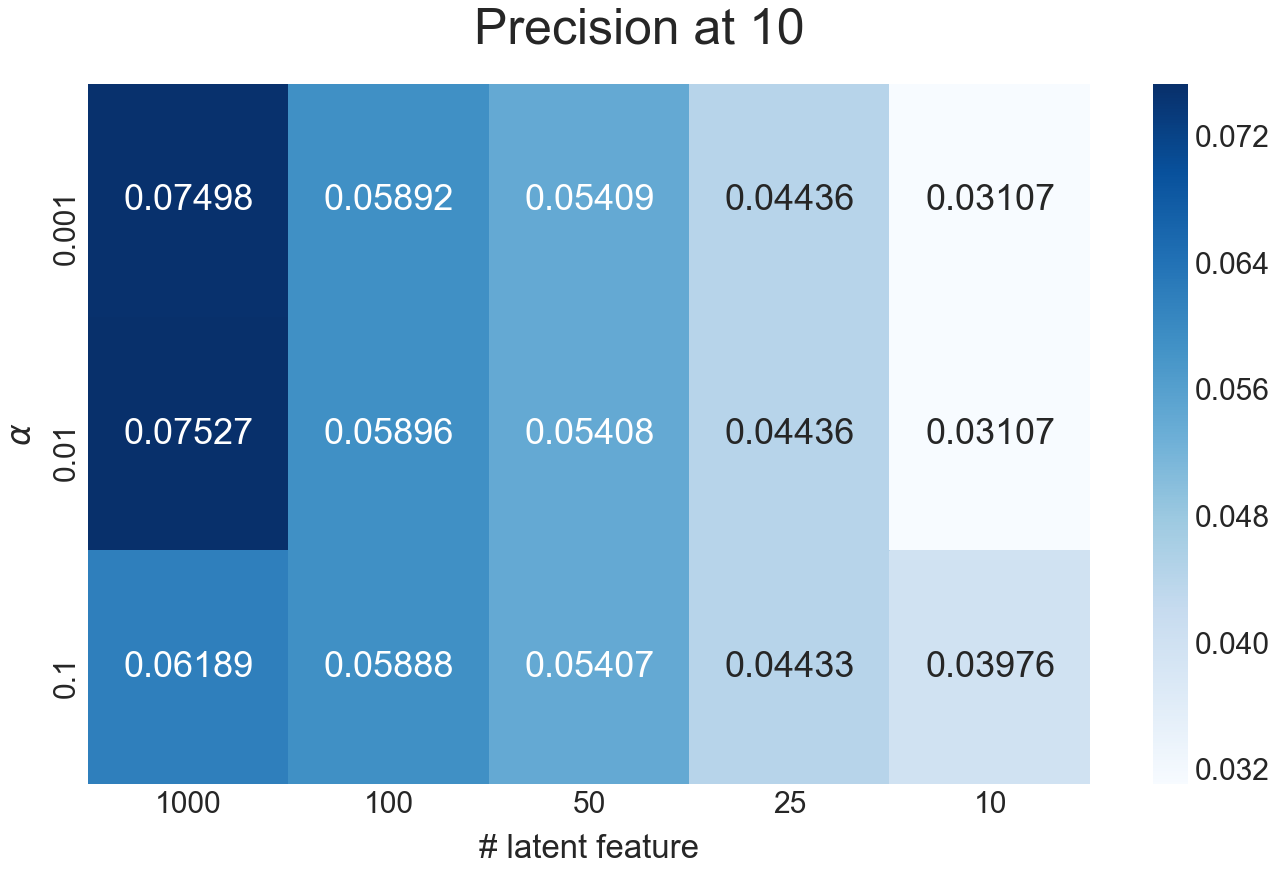

In [30]:
import seaborn as sn
from matplotlib.pyplot import cm
fig = plt.figure(figsize = (20,12), facecolor = 'white')
sn.set(font_scale = 3)
sn.heatmap(pk_df, cmap = cm.Blues, annot = True, fmt=".4g")
plt.title('Precision at 10', fontsize = 50, x = 0.55, y = 1.05)
plt.xlabel('# latent feature', labelpad = 15)
plt.ylabel(r'$\alpha$', labelpad = 15)
plt.savefig('pk_heatmap.png', facecolor = 'white', bbox_inches = 'tight')

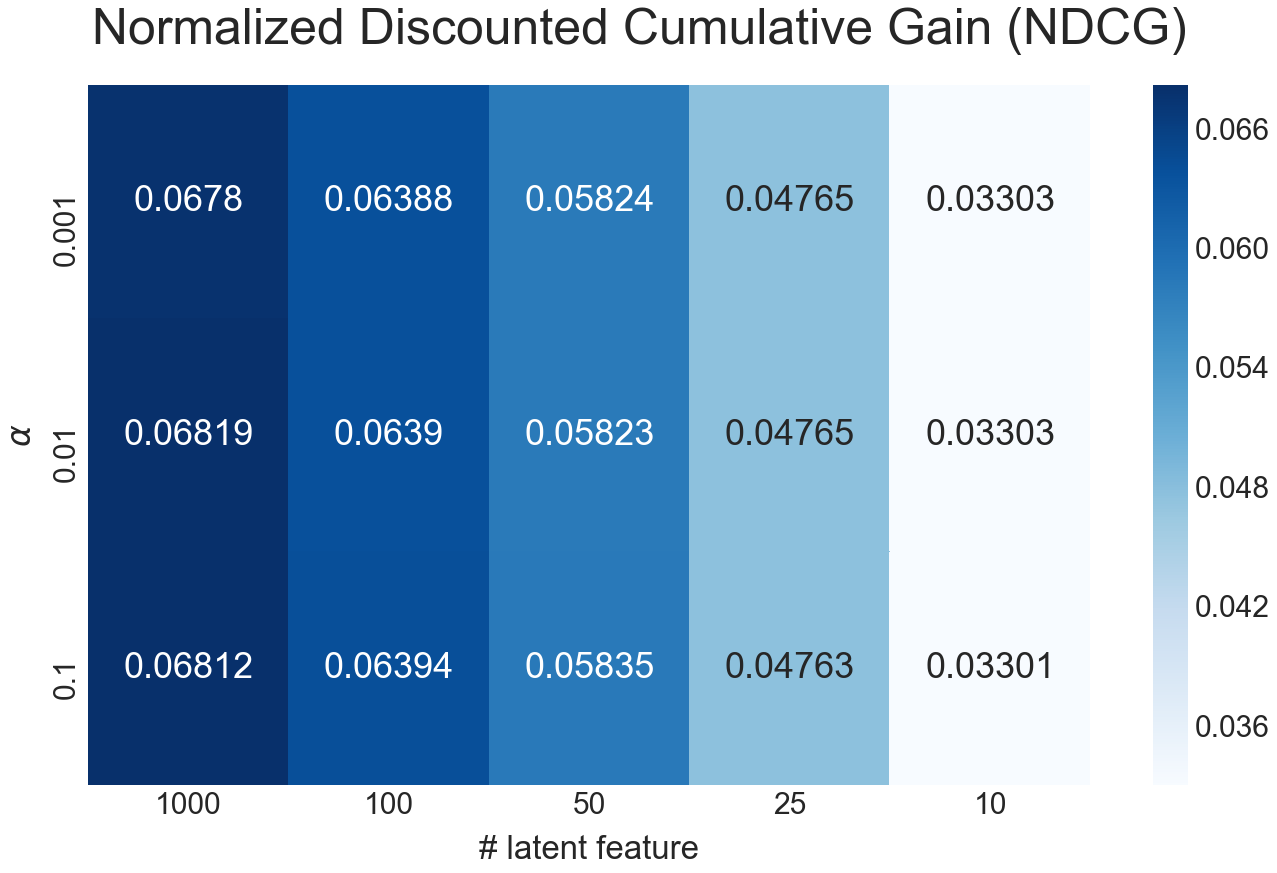

In [69]:
fig = plt.figure(figsize = (20,12), facecolor = 'white')
sn.set(font_scale = 3)
sn.heatmap(ndcg_df, cmap=cm.Blues, annot = True, fmt=".4g")
plt.title('Normalized Discounted Cumulative Gain (NDCG)', fontsize = 50, x = 0.55, y = 1.05)
plt.xlabel('# latent feature', labelpad = 15)
plt.ylabel(r'$\alpha$', labelpad = 15)
plt.savefig('ndcg_heatmap.png', facecolor = 'white', bbox_inches = 'tight')

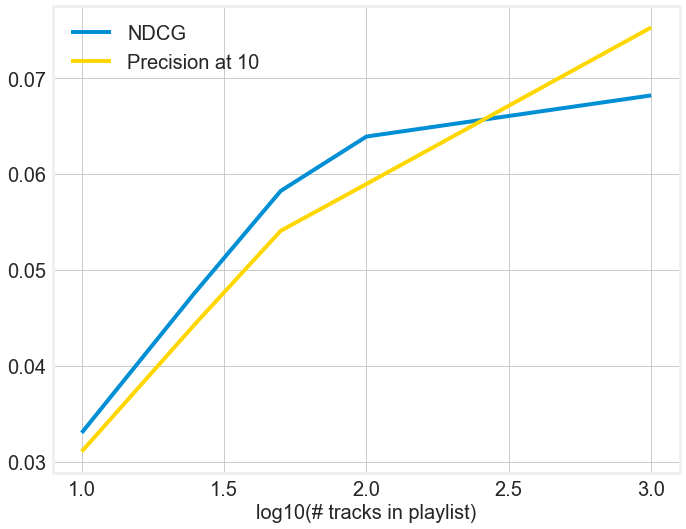

In [99]:
fig = plt.figure(figsize=(10,8), facecolor = 'white')
ax = fig.add_subplot(111, facecolor='white')
ax.plot([np.log10(int(i)) for i in ndcg_df.columns],ndcg_df.loc['0.01'], label = 'NDCG')
ax.plot([np.log10(int(i)) for i in pk_df.columns],pk_df.loc['0.01'], label= 'Precision at 10', c = '#FFD700')
ax.set_xlabel('log10(# tracks in playlist)', size = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(facecolor = 'white', fontsize = 20)
plt.savefig('pk_ndcg.png', facecolor = 'white', bbox_inches = 'tight')
plt.show()

# Train Model

From the result of grid search, we decided to use n_compnents=1000 and alpha=0.01 as our hyper parameter. 

## Test set

In [74]:
n_ = 1000
alpha_=0.01
info = ''.join(['n', str(n_), '_', 'a', ''.join(re.findall('[0-9]+', str(alpha_))), '_ndcgok'])
file_path = "pickles/model/ndcg_val/als_"+info+".pkl"
with open(file_path, "rb") as file:
    model, W, H, info, precision, average_ndcg = pickle.load(file)

In [ ]:
# recommend items for a user
pred = []
user_items = X_train.tocsr()
for userid in range(X_train.shape[0]):
    temp = []
    filter_items = user_items[userid,:].nonzero()[1].tolist()
    temp_rec = model.recommend(userid,
                               user_items=user_items,
                               filter_items=filter_items)
    for tup in temp_rec:
        temp.append(tup[0])
    pred.append(temp)

# calculate precision@k and NDCG@k
precision = precision_at_k(X_test, pred)
average_ndcg = cal_ndcg(X_test, pred)

In [ ]:
print('precision at 10 (test set)=', precision)
print('ndcg at 10 (test set)=', ndcg)

## Baseline

The baseline we use is recommending the top 10 tracks to each playlist.

In [70]:
# reporting our model performence using test set
prediction = []
pop = popular_tracks_idx[:260]
for i in range(X_train_csr.shape[0]):
    print('playlist', i)
    in_train = X_train_csr[i,:].nonzero()[1].tolist()
    rec = [n for n in pop if n not in in_train][:10]
    prediction.append(rec)

In [ ]:
precision = precision_at_k(X_test, prediction)
ndcg = cal_ndcg(X_test, prediction)

In [ ]:
print('precision at 10 (baseline) =', precision)
print('ndcg at 10 (baseline) =', ndcg)

# Appendix - The NMF Model

The code for training the nmf model with scikit learn.
The trained model can be found at the following link:
https://drive.google.com/open?id=1bDK1R_kjdoGLdLfjfX7d6rMjzVCigNpY

In [ ]:
from sklearn.decomposition import NMF
model_6 = NMF(n_components=10,
            alpha=0.001,
            random_state=95865,
            init='nndsvdar',
            solver='mu',
            beta_loss='kullback-leibler',
            l1_ratio=0,
            verbose=True)

W_6 = model_6.fit_transform(X_train)
H_6 = model_6.components_